In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf  
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import os

## Prepare Training Data

In [14]:
data_set = 'dogs-vs-cats'
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/IMAGE CLASSIFICATION/DOGS VS. CATS- CNN/kagglecatsanddogs_3367a.zip", 'r') as zip_ref:
  zip_ref.extractall('./')

In [15]:
# Delete unnecessary folders

In [16]:
os.listdir('./')

['.config',
 'drive',
 'PetImages',
 'MSR-LA - 3467.docx',
 'readme[1].txt',
 'sample_data']

In [17]:
os.remove('./readme[1].txt')

In [18]:
os.remove('./MSR-LA - 3467.docx')

In [19]:
os.listdir('./')

['.config', 'drive', 'PetImages', 'sample_data']

In [21]:
my_data_dir = './PetImages/' #creating a variable for image folder

In [22]:
os.listdir(my_data_dir)

['Cat', 'Dog']

**Filter out corrupted images**

When working with lots of real-world image data, corrupted images are a common occurrence.
Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [23]:
num_skipped = 0
for folder_name in ("Cat", 'Dog'):
  folder_path = os.path.join('PetImages', folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, 'rb')
      is_jfif= tf.compat.as_bytes('JFIF') in fobj.peek(10) #tf.compat.as_bytes Converts bytearray, bytes, or unicode python input types to bytes
    finally:
      fobj.close()
    if not is_jfif:
      num_skipped +=1
      #delete corrupted image
      os.remove(fpath)
print("Delete %d images" %num_skipped)

Delete 1590 images


In [24]:
len(os.listdir(my_data_dir + '/Cat')) #there are 11742 label Cat

11742

In [25]:
len(os.listdir(my_data_dir + '/Dog'))

11670

## Using image data_augmentation or ImageDataGenerator


When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

Image DataGenerator

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
#help(ImageDataGenerator)

Image Manipulation


We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings;


- Accepts a batch of images used for training.
- Applies a series of random transformations to each image in the batch.
- Replaces the original batch with randomly transformed batch.
- Training the CNN on this randomly transformed batch.


The goal of applying data augmentation is to have a more generalized model.

In [28]:
image_gen = ImageDataGenerator(rotation_range = 20, #rotate image 20 degress
                               width_shift_range = 0.10,
                               height_shift_range = 0.10,
                               rescale = 1/255, #rescale tthe image by normalizing it 
                               shear_range = 0.1, #cutting away part of the image
                               zoom_range = 0.1, #zoom in by 10%
                               horizontal_flip = True, 
                               fill_mode = 'nearest' #fill in missing pixels with the nearest filled value
                               )

In [29]:
cat_image_path = my_data_dir + '/Cat' + '/0.jpg' #/0.jpg is first image
dog_image_path = my_data_dir + '/Dog' + '/0.jpg'

In [30]:
cat_img = imread(cat_image_path)
dog_img = imread(dog_image_path)

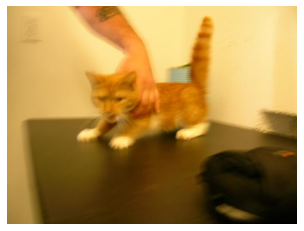

In [31]:
plt.imshow(cat_img)
plt.axis('off');

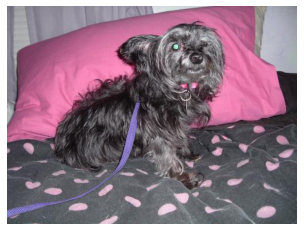

In [32]:
plt.imshow(dog_img)
plt.axis('off');

Transform the images with ImageDataGenerator

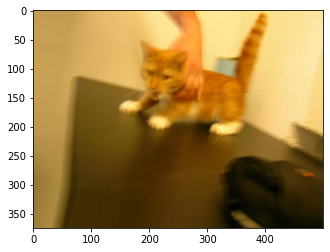

In [33]:
plt.imshow(image_gen.random_transform(cat_img))

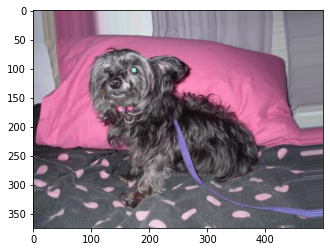

In [34]:
plt.imshow(image_gen.random_transform(dog_img));

Transform the images with Data_Augmentation

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset

In [35]:
import tensorflow_datasets as tfds
(train_ds, val_ds, test_ds), metadata = tfds.load('CatsVsDogs',
  split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
  with_info = True,
  as_supervised = True )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete0FEGB4/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [36]:
#labels 
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


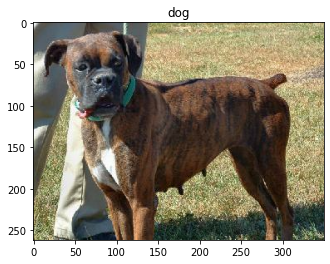

In [37]:
get_label_name = metadata.features['label'].int2str
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [38]:
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
data_augmentation = tf.keras.Sequential([
            layers.RandomFlip('horizontal_and_vertical'),
            layers.RandomRotation(0.2),
])

In [40]:
image = tf.expand_dims(image,0)

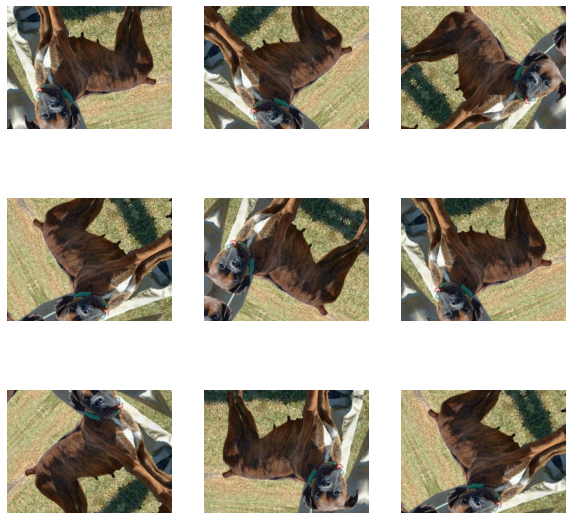

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

Creating the Model

In [42]:
image_shape = (128,128,3)

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [44]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) #Flatten is used to flatten the input
model.add(Dense(128)) #Dense Layer is used to classify image based on output from convolutional layers.
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics =['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)      

Split our data into train, test and validation

In [46]:
!pip install split-folders

In [47]:
import splitfolders

In [48]:
os.makedirs('./PetImages2')

create an empty folder named PetImages2 and put the split datasets there.

In [49]:
pwd

'/content'

In [50]:
input_folder ='./PetImages'
output_folder = './PetImages2'

In [51]:
#split into train, val, test
splitfolders.ratio(input_folder, output= output_folder, seed=4, ratio = (.7,.2,.1), group_prefix= None)

Copying files: 23412 files [00:13, 1737.84 files/s]


In [52]:
os.listdir('./')

['.config', 'drive', 'PetImages2', 'PetImages', 'sample_data']

Now in PetImages2 there are 3 folders named val, train, test

Specify the Folder paths

In [53]:
#delete PetImages folder
import shutil
shutil.rmtree('./PetImages')

In [54]:
os.listdir('./')

['.config', 'drive', 'PetImages2', 'sample_data']

In [55]:
my_data_dir = './PetImages2'
my_data_dir

'./PetImages2'

In [56]:
os.listdir(my_data_dir)

['train', 'val', 'test']

In [57]:
val_path = my_data_dir + '/val/' #/val/ is folder
train_path = my_data_dir + '/train/'
test_path = my_data_dir + '/test/'

In [58]:
os.listdir(train_path)

['Cat', 'Dog']

In [59]:
# Train
len(os.listdir(train_path+'/Cat')), len(os.listdir(train_path+'/Dog'))

(8219, 8168)

In [60]:
# Test
len(os.listdir(test_path+'/Cat')), len(os.listdir(test_path+'/Dog'))

(1175, 1168)

In [61]:
# Val
len(os.listdir(val_path+'/Cat')), len(os.listdir(val_path+'/Dog'))

(2348, 2334)

flow_from_directory

Generating many manipulated images from a directory
flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [ ]:
image_gen

In [63]:
image_gen.flow_from_directory(train_path)

Found 16387 images belonging to 2 classes.


In [64]:
image_gen.flow_from_directory(val_path)

Found 4682 images belonging to 2 classes.


In [65]:
image_gen.flow_from_directory(test_path)

Found 2341 images belonging to 2 classes.


Early Stopping

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

In [67]:
early_stop = EarlyStopping(monitor ='val_loss', patience=2)

In [68]:
batch_size = 16

In [69]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')           

Found 16387 images belonging to 2 classes.


In [75]:
val_image_gen = image_gen.flow_from_directory(val_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 4682 images belonging to 2 classes.


In [70]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2341 images belonging to 2 classes.


In [71]:
train_image_gen.class_indices

{'Cat': 0, 'Dog': 1}

MODEL TRAINING

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [76]:
results = model.fit_generator(train_image_gen, epochs = 10,
                              validation_data = val_image_gen, 
                              callbacks=[early_stop])

Epoch 1/10
1025/1025 [==============================] - 595s 578ms/step - loss: 0.6740 - accuracy: 0.5735 - val_loss: 0.6455 - val_accuracy: 0.6395
Epoch 2/10
1025/1025 [==============================] - 582s 568ms/step - loss: 0.5994 - accuracy: 0.6837 - val_loss: 0.5382 - val_accuracy: 0.7294
Epoch 3/10
1025/1025 [==============================] - 568s 554ms/step - loss: 0.5424 - accuracy: 0.7299 - val_loss: 0.4996 - val_accuracy: 0.7636
Epoch 4/10
1025/1025 [==============================] - 567s 553ms/step - loss: 0.5124 - accuracy: 0.7468 - val_loss: 0.4851 - val_accuracy: 0.7668
Epoch 5/10
1025/1025 [==============================] - 568s 554ms/step - loss: 0.4856 - accuracy: 0.7656 - val_loss: 0.4852 - val_accuracy: 0.7721
Epoch 6/10
1025/1025 [==============================] - 574s 560ms/step - loss: 0.4670 - accuracy: 0.7806 - val_loss: 0.4302 - val_accuracy: 0.8005
Epoch 7/10
1025/1025 [==============================] - 564s 550ms/step - loss: 0.4568 - accuracy: 0.7901 - val_

Evaluating the Model

In [78]:
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.673963,0.573503,0.645527,0.639470
1,0.599414,0.683713,0.538227,0.729389
2,0.542444,0.729908,0.499633,0.763563
3,0.512425,0.746812,0.485098,0.766766
4,0.485582,0.765607,0.485241,0.772106


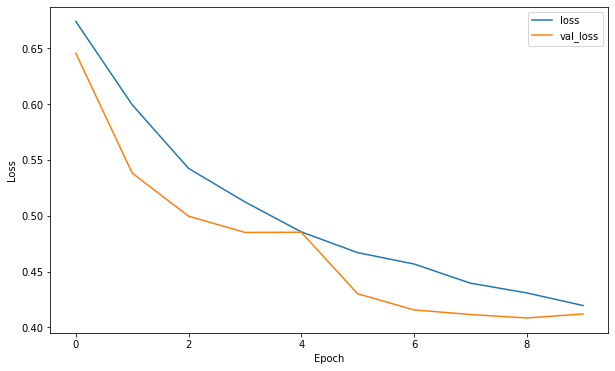

In [79]:
plt.figure(figsize=(10,6))
plt.plot(summary.loss, label='loss')
plt.plot(summary.val_loss, label="val_loss")
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

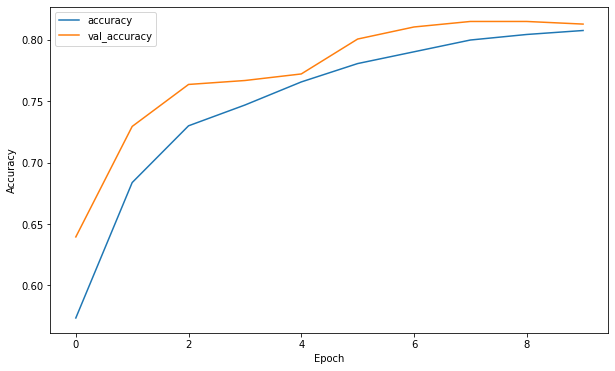

In [80]:
plt.figure(figsize=(10,6))
plt.plot(summary.accuracy, label="accuracy")
plt.plot(summary.val_accuracy, label="val_accuracy")
plt.legend(loc="upper left")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [89]:
predictions_probabilities = model.predict(val_image_gen)

In [90]:
predictions_probabilities

array([[0.01089218],
       [0.5155746 ],
       [0.31761453],
       ...,
       [0.6008394 ],
       [0.8428751 ],
       [0.9191848 ]], dtype=float32)

In [91]:
predictions = predictions_probabilities > 0.5

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

In [92]:
print(classification_report(val_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      2348
           1       0.80      0.86      0.83      2334

    accuracy                           0.82      4682
   macro avg       0.82      0.82      0.82      4682
weighted avg       0.82      0.82      0.82      4682



In [94]:
confusion_matrix(val_image_gen.classes, predictions)

array([[1836,  512],
       [ 333, 2001]])